In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.interpolate import InterpolatedUnivariateSpline

## SPARC Activity

In the following activity you will download rotation curve data of different galaxies from the Spitzer Photometry & Accurate Rotation Curves (SPARC) database and plot them with and without a dark matter component to understand the "missing mass" problem. 

1. Go to http://astroweb.cwru.edu/SPARC/ and under "BASIC SPARK DATA", download the Rotmod_LTG.zip file for "Newtonian Mass Models".
2. Open (extract/unzip) the zip file to preferably the same location as where your Python notebook is located. 
3. Choose a galaxy (any file) of your choice. Do not rename the file. Put the name of the chosen galaxy in the variable in the cell below and run it.

In [2]:
#Your_Galaxy='NGC0891' #for example: NGC0891
Your_Galaxy='NGC5005'

4. Make a note of the directory (file location) of the SPARC file of your galaxy **with respect to this location of this python notebook**. For example, if your file is located in the same location as this code, leave the following cell as is. But if it is, say, in the next folder "up" from this one, use the extension '../'. So an example of if the SPARC file is located two folders then one folder "down" (into a different folder named, say, 'otherfolder'), you would write:
`SPARC_file_directory='../../otherfolder/'` in the cell below and run it.

In [3]:
SPARC_file_directory='data/sparc/'                       #note that '' means the string variable is blank

5. All of the downloaded files are named as "[galaxy name]\_rotmod.dat" so you can define the file path by chosing the relevant file directory + your filename.

In [4]:
# Define file path for .dat files
SPARC_file_path = SPARC_file_directory + Your_Galaxy + '_rotmod.dat'

# Load the galaxy data
data = np.loadtxt(SPARC_file_path)

6. Print the header to see what variable each column corresponds to.

In [5]:
# Print header 
for lines in open(SPARC_file_path, 'r'):
    if lines.startswith('#'):
        print(lines)

# Distance = 16.9 Mpc

# Rad	Vobs	errV	Vgas	Vdisk	Vbul	SBdisk	SBbul		

# kpc	km/s	km/s	km/s	km/s	km/s	L/pc^2	L/pc^2



7. Split columns into arrays and name them according to the header displayed in the cell above.  <br>
        Rad: distance from the center of galaxy (in kpc) 
        Vobs: observed velocity/measured datapoints (in km/s) 
        errV: uncertainty in the observed velocity (in km/s) 
        Vgas: velocity of the gas component (in km/s) 
        Vdisk: velocity of the disk component (in km/s)
        Vbul: velocity of the bulge component (in km/s)
        SBdisk: surface brightness of the disk component (in Luminosity/pc^2) 
        SBbul: surface brightness of the bulge component (in Luminosity/pc^2)

In [6]:
# Split columns into arrays
Rad,Vobs,errV,Vgas,Vdisk,Vbul,SBdisk,SBbul = data.T     

8. The distance to the galaxy is given in the data file in Megaparsecs (equal to about 3.26 million light years). You can define this value in your Python notebook for your reference. 

In [7]:
# Define distance in Mpc
firstline = open(SPARC_file_path).readline()
firstline = firstline.split()
distance = float(firstline[3])
print("The distance to {} galaxy is {} Mpc.".format(Your_Galaxy,distance))

The distance to NGC5005 galaxy is 16.9 Mpc.


9. Due to the low number of datapoints, the rotation curve might look choppy. In order to smooth it, you can define a polynomial using Scipy's Interpolated Univariate Spline function, then chose your range and number of datapoints (sampling radii) to calculate the curve of each component. 

In [8]:
# Interpolation function
def interpd(x,y):
    return InterpolatedUnivariateSpline(x,y,k=5)

# Bulge
def bulge(r):
    polynomial = interpd(Rad,Vbul)   
    return polynomial(r)

# Disk
def disk(r):
    polynomial = interpd(Rad,Vdisk)   
    return polynomial(r)

# Gas 
def gas(r):
    polynomial = interpd(Rad,Vgas)   
    return polynomial(r)

## Observed velocity of the chosen galaxy

10. Let's plot the observed velocity (measured datapoints) of the chosen galaxy.

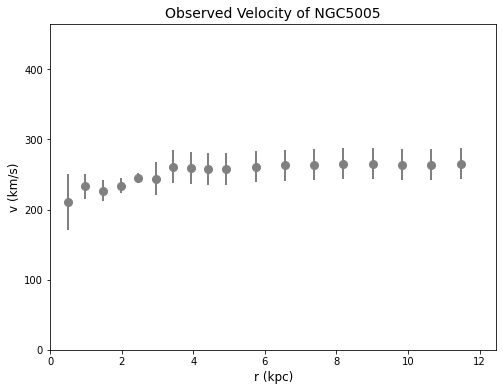

In [9]:
plt.figure(figsize=(8,6))                                                # size of the galaxy
plt.errorbar(Rad,Vobs,yerr=errV, marker='o', markersize=8, \
             ecolor='gray',color='gray', linestyle='none', linewidth=2)  # plot datapoints with errorbars
plt.xlabel('r (kpc)',size=12)                                            # label x-axis
plt.ylabel('v (km/s)',size=12)                                           # label y-axis
plt.title(str('Observed Velocity of ' + Your_Galaxy), size=14)           # title of the plot
plt.xlim(0,np.max(Rad + 1))                                              # range of the x-axis
plt.ylim(0,np.max(Vobs + 200))                                           # range of the y-axis
plt.show()                                                               # show the plot

11. A prefactor or mass-to-light ratio ($\Upsilon$) is added to each component which will be useful when fitting the curve of each component. These prefactors help scaling the curve up and down. You can change these values and see the magnitude of the relevant curve change in the cells below. <br>
        pref_bulge: bulge prefactor
        pref_disk: disk prefactor
    Note that the gas prefactor is missing. This is because....need sources!

In [10]:
# Prefactors
pref_disk = 0.5
pref_bulge = 0.4

# Radius for plotting
radius = np.linspace(0.001,np.max(Rad),100)       # starting at 0.001 to avoid dividing by zero, 
                                                  # ending at the same radius where the given datapoints end, 
                                                  # with 100 datapoints

## Rotational velocity of each luminous component

12. Let's plot the rotation velocity of each component, multiplied by the square root of the given prefactor. (Note: you will see later why the square root of the prefactor is needed here.)

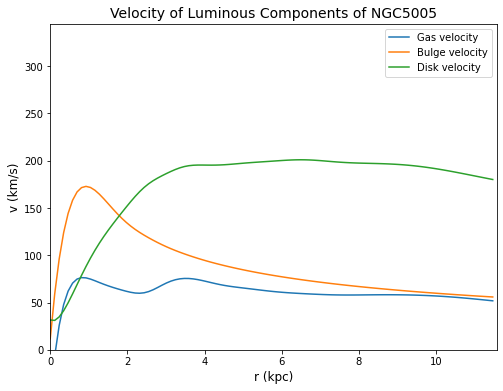

In [11]:
plt.figure(figsize=(8,6))
plt.plot(radius, gas(radius),   label="Gas velocity")
plt.plot(radius, np.sqrt(pref_bulge) * bulge(radius), label="Bulge velocity")
plt.plot(radius, np.sqrt(pref_disk)* disk(radius),  label="Disk velocity")
plt.xlabel('r (kpc)',  size=12)
plt.ylabel('v (km/s)', size=12)
plt.title(str('Velocity of Luminous Components of ' + Your_Galaxy), size=14)
plt.xlim(0,np.max(Rad + 0.1))
plt.ylim(0,np.max(Vobs + 80))
plt.legend()                                                             # show the labels of each curve
plt.show()

## Total velocity curve of baryonic matter

13. Now that we have all of the luminous components: bulge, disk and gas, we can add them in quadrature with equivalent prefactors to get the total velocity of the luminous or baryonic matter. You might notice now that although each component is squared, the prefactors are not. This is just how we define them in the equation (hence the square root in the previous cells if we are only considering one of the components). 

>__Total velocity of baryonic matter__: <br>
    \begin{equation}
    v_{total,bary}(r) = \sqrt{\lvert v_{gas}\rvert v_{gas} + \Upsilon _{bulge} \lvert v_{bulge}\rvert v_{bulge} + \Upsilon _{disk} \lvert v_{disk}\rvert v_{disk}}
    \end{equation}<br>

In [12]:
def total_velocity_bary(r,pref_bulge,pref_disk):             
    return np.sqrt(gas(r)**2 + pref_bulge*bulge(r)**2 + pref_disk*disk(r)**2)

14. Plot the luminous components and the total velocity.

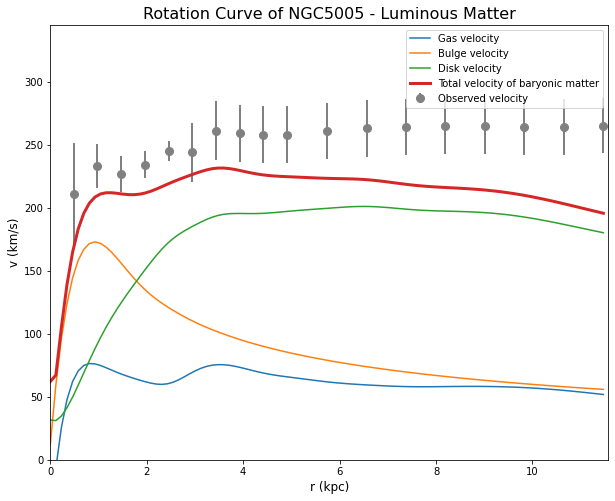

In [13]:
plt.figure(figsize=(10,8))

plt.plot(radius, gas(radius),                         label="Gas velocity",   color='#1f77b4')
plt.plot(radius, np.sqrt(pref_bulge) * bulge(radius), label="Bulge velocity", color='#ff7f0e')
plt.plot(radius, np.sqrt(pref_disk)* disk(radius),    label="Disk velocity",  color='#2ca02c')

plt.plot(radius,total_velocity_bary(radius,pref_bulge,pref_disk), label="Total velocity of baryonic matter", color='#d62728', linewidth=3)
plt.errorbar(Rad,Vobs,yerr=errV, marker='o', markersize=8, \
             ecolor='gray',color='gray', linestyle='none', linewidth=2, label = "Observed velocity")
plt.xlabel('r (kpc)',size=12)
plt.ylabel('v (km/s)',size=12)
plt.title(str('Rotation Curve of ' + Your_Galaxy + ' - Luminous Matter'), size=16)
plt.xlim(0,np.max(Rad + 0.1))
plt.ylim(0,np.max(Vobs) + 80)
plt.legend()
plt.show()

15. Notice that the total velocity does not align with the measured velocity. Not even if you scale the other components up and down with the prefactor. Let's add the "missing matter".

## Add dark matter

16. Dark matter can be characterized by two parameters: the central mass density and the cutoff radius. <br>
***Central mass density***: The central mass density is the density at the center of the galaxy, changing this value changes the magnitude of the dark matter curve. <br>
***Cutoff radius***: The cutoff radius (also called "scale radius") indicates where the density falls off by a factor of e (~2.7). Adjusting this factor changes where the "bump" of the curve is located.

>__Velocity__: <br>
    \begin{equation}
    v_{DM}(r) = \sqrt{4 \pi G \rho_{0} r_c^2 \big( 1- \frac{r_c}{r} \arctan{\frac{r}{r_c}}\big)}
    \end{equation}<br>
    
   >where:<br>
        $G$ = gravitational constant<br>
        $\rho_0$ = central mass density (in solar mass/$\rm kpc^3$)<br>
        $r_c$ = cutoff radius (in kpc)<br>

In [14]:
# Set parameters
rho0 = 3.10e8       # central mass density (in solar mass/kpc^3)
rc = 1.4            # cutoff radius (in kpc)
G = 4.300e-6        # Gravitational constant (kpc/solar mass*(km/s)^2)

# Equation for dark matter halo velocity
def halo(r,rho0,rc):
    v = np.sqrt(4*np.pi*G*rho0*rc**2*(1 - rc/r * np.arctan(r/rc)))
    return v

17. Now, calculate the total velocity with the dark matter component included. 

In [15]:
def total_velocity_withDM(r,pref_bulge,pref_disk,rho0,rc):             
    return np.sqrt(gas(r)**2 + pref_bulge*bulge(r)**2 + pref_disk*disk(r)**2 + halo(r,rho0,rc)**2)

18. Plot all components and the total velocity with the dark matter.

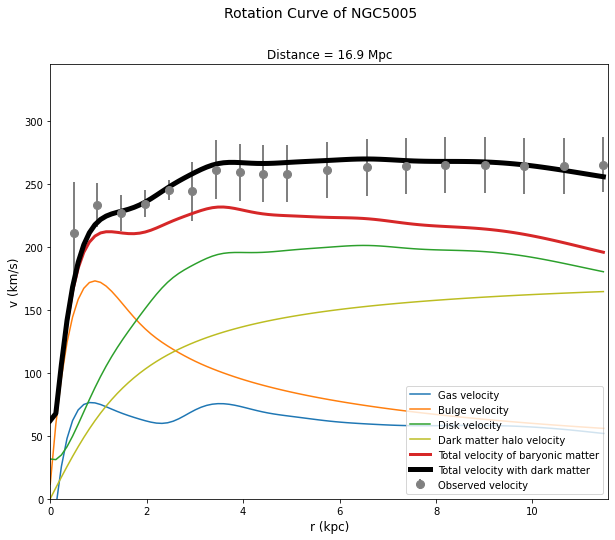

In [16]:
plt.figure(figsize=(10,8))

plt.plot(radius, gas(radius),                         label="Gas velocity",   color='#1f77b4')
plt.plot(radius, np.sqrt(pref_bulge) * bulge(radius), label="Bulge velocity", color='#ff7f0e')
plt.plot(radius, np.sqrt(pref_disk)* disk(radius),    label="Disk velocity",  color='#2ca02c')
plt.plot(radius, halo(radius,rho0,rc),                label="Dark matter halo velocity",  color='#bcbd22')

plt.plot(radius,total_velocity_bary(radius,pref_bulge,pref_disk), label="Total velocity of baryonic matter", color='#d62728', linewidth=3)
plt.plot(radius,total_velocity_withDM(radius,pref_bulge,pref_disk,rho0,rc), label="Total velocity with dark matter", color='k', linewidth=5)

plt.errorbar(Rad,Vobs,yerr=errV, marker='o', markersize=8, \
             ecolor='gray',color='gray', linestyle='none', linewidth=2, label = "Observed velocity")
plt.xlabel('r (kpc)',size=12)
plt.ylabel('v (km/s)',size=12)
plt.suptitle(str('Rotation Curve of ' + Your_Galaxy), size=14)
plt.title(str('Distance = {} Mpc'.format(distance)), size=12)
plt.xlim(0,np.max(Rad + 0.1))
plt.ylim(0,np.max(Vobs) + 80)
plt.legend(loc='lower right')
plt.show()

# References <br>
>Lelli, Federico, Stacy S. McGaugh, and James M. Schombert. __“SPARC: Mass Models for 175 Disk Galaxies with Spitzer Photometry and Accurate Rotation Curves.”__ _The Astronomical Journal 152_, no. 6 (2016): 157. https://doi.org/10.3847/0004-6256/152/6/157. <br><br>
>“Megaparsec: Cosmos.” __Megaparsec__ | _COSMOS_. Swinburne University of Technology. Accessed November 12, 2021. https://astronomy.swin.edu.au/cosmos/m/megaparsec. 
***